In [1]:
#!pip3 install -U ucimlrepo 

#### 
The helper modules for data loading and exploration are already imported. The **data_loader** module loads the "auto_mpg" dataset, and **data_explorer** extracts and prints the dataset's metadata.

In [2]:
from utils import data_loader as dl
from utils import data_explorer as de
import numpy as np

data_loader = dl.DataLoader()
auto_mpg_data = data_loader.get_dataset("auto_mpg")
data_explorer = de.DataExplorer(auto_mpg_data)
metadata = data_explorer.describe_data()
print(metadata)


Loading dataset: auto_mpg...
Loading Auto MPG dataset from local storage...
    Column Name Data Type
0  displacement   float64
1     cylinders     int64
2    horsepower   float64
3        weight     int64
4  acceleration   float64
5    model_year     int64
6        origin     int64
7           mpg   float64


#### **Step 1**: Check for Missing Data

Check if there are any missing values in the dataset and removing rows that contain missing data.

**Task:**

- Check for columns with missing values.
- Remove the rows with missing values.
- Print out the number of rows before and after cleaning. Expected answer: 398 and 392


In [3]:
ch_missing_data = auto_mpg_data.isna().sum()
missing_columns = ch_missing_data[ch_missing_data > 0].index  
rows_with_missing_data = auto_mpg_data[auto_mpg_data[missing_columns].isna().any(axis=1)]
print(f"Features with missing data: {missing_columns[0]}")
print(f"rows with missing data {rows_with_missing_data.shape[0]}")
df = auto_mpg_data.dropna()
print(f"Number of samples Raw dataset: {auto_mpg_data.shape[0]}")
print(f"Number of samples cleaned dataset: {df.shape[0]}")

Features with missing data: horsepower
rows with missing data 6
Number of samples Raw dataset: 398
Number of samples cleaned dataset: 392


#### **Step 2**: Define your target variable (mpg) and features (all other numerical columns), and then split the data into training and testing sets.

**Task**:

- Define the target (mpg) and select the numerical columns as features.
- Split the data into training and testing sets (80% training, 20% testing).

In [4]:
target = 'mpg'
numerical_cols = df.select_dtypes(include=[np.number]).columns
features = numerical_cols[numerical_cols != target]

X = df[features].values
y = df[target].values

#### **Step 3**: Preprocess the Data (Scaling)
Preprocess the data by normalizing the features using StandardScaler. This is an important step to ensure that the features are on the same scale.

**Task**:

- Normalize the training and testing features using the StandardScaler.
- Convert the data to PyTorch tensors.

In [5]:
### Pre-processing step. 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features using the training data only
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Convert the data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Shape should be (n_samples, 1)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

#### **Step 4**:  Build the Neural Network Model
Define and build the neural network model. For this task, you will use `PyTorch` to define a simple feedforward neural network with one hidden layer. The model will take the normalized features as input and output the predicted fuel efficiency (MPG).


**Task**:

- Define a neural network model using nn.Sequential() or by creating a custom class that inherits from nn.Module.
- The model should include:
    - An input layer that matches the number of features.
    - At least one hidden layer of 64 neuros and a ReLU activation function.
    - An output layer with one neuron (since the target is a single continuous value).

In [6]:
import torch.nn as nn
import torch.optim as optim
import pandas as pd

hidden_sizes = [64]
output_size = 10
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])  
        self.relu = nn.ReLU()                 
        self.fc2 = nn.Linear(hidden_sizes[0], 1)           

    def forward(self, x):
        x = self.fc1(x)      
        x = self.relu(x)     
        x = self.fc2(x)      
        return x


input_size = X_train.shape[1]  
model = SimpleNN(input_size)

#### **Step 5**:  Train the Neural Network Model
Train the neural network model. This involves defining the loss function, specifying the optimizer, and running the training loop. The goal is to minimize the loss (difference between the predicted and actual MPG values) using gradient descent.

**Task**:

- Define a loss function (e.g., Mean Squared Error for regression tasks).
- Choose an optimizer (e.g., Adam, which is commonly used for neural network training).
- Write the training loop where the model learns from the training data, calculates the loss, and updates the weights through backpropagation.

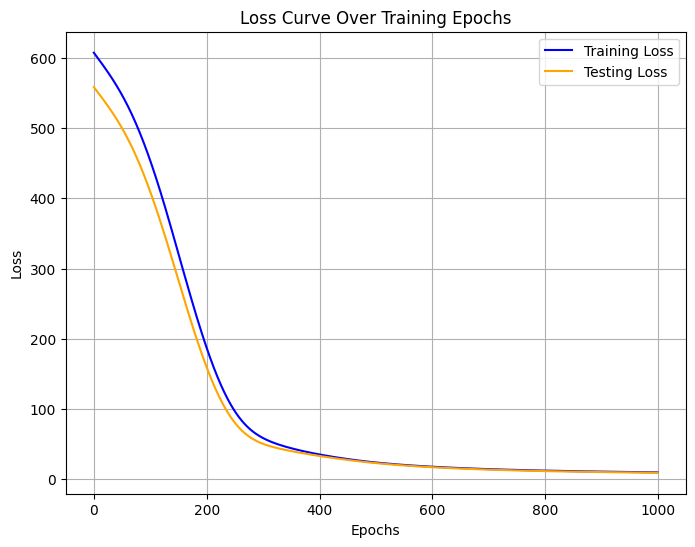

In [7]:
criterion = nn.MSELoss()          
optimizer = optim.Adam(model.parameters(), lr=0.001)  

loss_values_train = []
loss_values_test = []
epochs = 1000
for epoch in range(epochs):
    model.train()  
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)  
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    loss_values_train.append(loss.item())
    
    # Testing phase (no gradient computation)
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test_tensor)
        loss_test = criterion(y_pred_test, y_test_tensor)
        loss_values_test.append(loss_test.item())

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(epochs), loss_values_train, label="Training Loss", color="blue")
plt.plot(range(epochs), loss_values_test, label="Testing Loss", color="orange")
plt.title("Loss Curve Over Training Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

#### **Step 6**:  Evaluate the Model's Performance
Evaluate how well the model performs on the train and test dataset that it has not seen before. This helps determine if the model generalizes well to new data or if it overfits to the training data.

**Task**:

- Use the trained model to make predictions on the train/test data.
- Calculate evaluation metrics :Mean Squared Error (MSE).
- Visualize the results using plots like predicted vs. actual values.

In [8]:
model.eval()

# Make predictions on the test set, Turn off gradient
with torch.no_grad():
    y_pred_test = model(X_test_tensor)

# Compute the Mean Squared Error
test_loss = criterion(y_pred_test, y_test_tensor)
print(f"Test Loss (MSE): {test_loss.item():.4f}")

with torch.no_grad():
    y_pred_train = model(X_train_tensor)

# Compute the Mean Squared Error
train_loss = criterion(y_pred_train, y_train_tensor)
print(f"Train Loss (MSE): {train_loss.item():.4f}")

y_pred_test  = y_pred_test.numpy()
y_pred_train = y_pred_train.numpy()

Test Loss (MSE): 9.4816
Train Loss (MSE): 10.0355


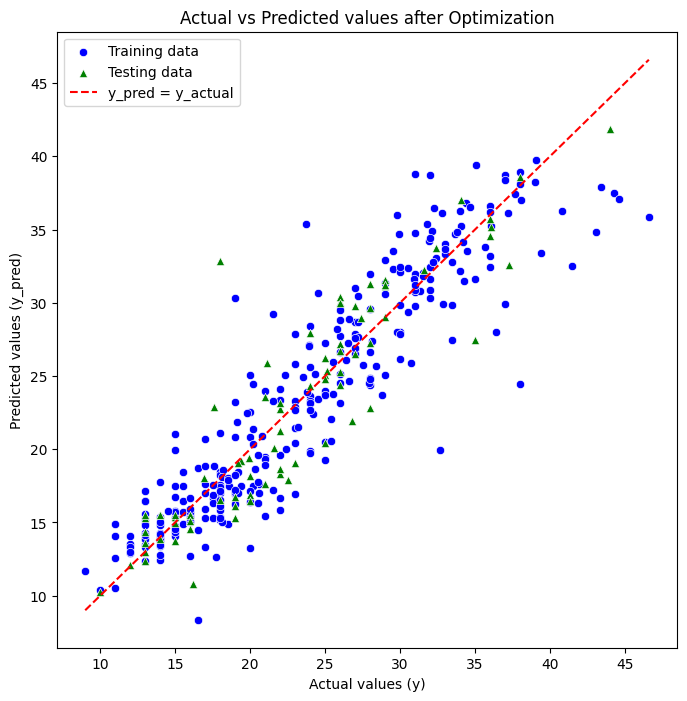

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


df_plot_train = pd.DataFrame({
    'Actual_train': y_train,
    'Predicted_train': y_pred_train.flatten()
})
min_train = df_plot_train['Actual_train'].min()
max_train = df_plot_train['Actual_train'].max()

df_plot_test = pd.DataFrame({
    'Actual_test': y_test,
    'Predicted_test': y_pred_test.flatten()
})

min_test = df_plot_test['Actual_test'].min()
max_test = df_plot_test['Actual_test'].max()

plt.figure(figsize = (8,8))
sns.scatterplot(data=df_plot_train, x='Actual_train', y='Predicted_train', color = 'blue', marker = 'o', label = 'Training data')
sns.scatterplot(data=df_plot_test, x='Actual_test', y='Predicted_test', color = 'green', marker = '^', label = 'Testing data')
plt.plot([min(min_train, min_test), max(max_train, max_test)], [min(min_train, min_test), max(max_train, max_test)], color='red', linestyle='--', label='y_pred = y_actual') 
plt.title('Actual vs Predicted values after Optimization')
plt.xlabel('Actual values (y)')
plt.ylabel('Predicted values (y_pred)')
plt.legend()
plt.show()

#### **Step 7**: Save the Model

**Task:**
- Save the trained model using PyTorch's `torch.save()` function.
- Ensure the model state dictionary (**model.state_dict()**) is saved, as it contains the model parameters.

In [10]:
checkpoint = {
    'input_size': input_size,  
    'output_size': output_size,  
    'hidden_layers': hidden_sizes,  
    'state_dict': model.state_dict()  
}

model_path = f"./models/{target}_predictor_model.pth"
torch.save(checkpoint, model_path)